<a href="https://colab.research.google.com/github/bagusgood/Radio_Fingerprint_6AP/blob/main/Localization_W_OSGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries and Prerequisite

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch.nn.functional as F

import scipy.io
import tensorflow as tf
import ipywidgets as widgets
from keras import initializers
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers.legacy import Adam
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.backend import clear_session
from keras.utils import to_categorical
from IPython.display import display
from keras.optimizers import Adam
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
from numpy.random import seed
from tqdm import tqdm

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from deepkan import RBFKAN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from keras.layers import Dense

## Parameters

In [ ]:
#Data Parameters
num_of_classes = 20
num_of_features = 6
data_shape = (num_of_features,1)

#MLP Parameters
times_to_run = 1 #Number of times to run MLP model
mlp_epochs = 40
valid_split = 0.25

#GAN Parameters
latent_dim = 100
gan_epochs = 1000

#Random Seeds
selection_seed = 150
seed_multiplier = 1000000

lr_mlp = 0.0002
lr_rbfkan = 0.0001

dataset_file = f"drive/MyDrive/dataset{num_of_features}AP.csv"
BASE_FOLDER = f"/content/drive/MyDrive/thesis//new/{num_of_features}AP/W_OSGAN/R10_R10"
os.makedirs(BASE_FOLDER, exist_ok=True)

In [ ]:
cb1 = widgets.Checkbox(description="Generate missing data only")
slider1 = widgets.FloatSlider(value=0.1, min=0.05, max=1, step=0.05)
slider2 = widgets.IntSlider(value=2, min=0, max=1000, step=250)
vb = widgets.VBox(children = [slider2])
def checkbox(button):
    if button['new']:
        vb.children = []
        slider2.value = 250 - int(slider1.value*250)
    else:
        vb.children = [slider2]
        experiment3 = False
cb1.observe(checkbox, names='value')

print("Percentage of Real Data:")
display(slider1)
print("Number of datapoints GAN generates:")
display(vb)
display(cb1)


Percentage of Real Data:


FloatSlider(value=0.1, max=1.0, min=0.05, step=0.05)

Number of datapoints GAN generates:


Checkbox(value=False, description='Generate missing data only')

In [ ]:
fraction_of_data = slider1.value
data_to_gen = slider2.value

In [ ]:
dataset = pd.read_csv(dataset_file)
labels = dataset.Class.values
labels = labels - 1 #Original label values are from 1 to 4
features = dataset.drop(columns='Class').values

In [ ]:
tr_fea, X_test, tr_label, Y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state= selection_seed,
                                                    stratify=labels)

In [ ]:
X_train = []
Z_train = [] #This is the same as X_train, but it's used for training the GAN
Y_train = []

for idx in range(num_of_classes):
    number_filter = np.where(tr_label == idx)
    X_filtered, Y_filtered = tr_fea[number_filter], tr_label[number_filter]

    num_of_data = (int)(fraction_of_data*X_filtered.shape[0])
    RandIndex = np.random.choice(X_filtered.shape[0],
                                 num_of_data,
                                 replace=False)
    Z_train.append(X_filtered[RandIndex])
    X_train.extend(X_filtered[RandIndex])
    Y_train.extend(Y_filtered[RandIndex])

X_train = np.asarray(X_train, dtype=np.float32)
Y_train = np.asarray(Y_train, dtype=np.float32)

X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

Y_train_encoded = to_categorical(Y_train)
Y_test_encoded = to_categorical(Y_test)

In [ ]:
#Data must be standized using standard scaler before using the MLP.
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.fit_transform(X_test)

In [ ]:
# Hyperparameters
input_dim = num_of_features
output_dim = num_of_classes
hidden_layers = [64, 128]  # Adjusted hidden layers
num_epochs = mlp_epochs  # Number of epochs
num_iterations = times_to_run  # Number of iterations (i)

# Split data into train, validation, and test sets
features_train, features_val, labels_train, labels_val = train_test_split(X_train_transformed, Y_train, test_size=valid_split, random_state=42)

features_test = X_test_transformed
labels_test = Y_test

# Convert to PyTorch tensors
features_train_tensor = torch.tensor(features_train, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train, dtype=torch.long)
features_val_tensor = torch.tensor(features_val, dtype=torch.float32)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.long)
features_test_tensor = torch.tensor(features_test, dtype=torch.float32)
labels_test_tensor = torch.tensor(labels_test, dtype=torch.long)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(features_train_tensor, labels_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(features_val_tensor, labels_val_tensor), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(features_test_tensor, labels_test_tensor), batch_size=64, shuffle=False)

# Store results
test_accuracies_mlp = []
test_accuracies_rbf = []

# Classification with MLP for Real Data

In [ ]:
# Simpan hasil
test_accuracies_mlp = []
all_test_loss = []
history = []

# Inisialisasi model terbaik
best_model_mlp = None
best_acc = 0

# Training loop
for i in range(times_to_run):
    seed(i * seed_multiplier)
    tf.random.set_seed(i * seed_multiplier)

    model = Sequential()
    model.add(Input(shape=(num_of_features,)))  # Define input shape explicitly
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_of_classes, activation='softmax'))

    model.compile(optimizer=Adam(lr_mlp, 0.5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history_temp = model.fit(X_train_transformed,
                            Y_train_encoded,
                            epochs=mlp_epochs,
                            batch_size=64,
                            validation_split=valid_split,
                            verbose=0)
    history.append(history_temp)

    test_loss, test_acc = model.evaluate(X_test_transformed, Y_test_encoded, verbose=0)

    print(f"#{i} Test acc:", test_acc)
    test_accuracies_mlp.append(test_acc)
    all_test_loss.append(test_loss)

    # Simpan model terbaik
    if test_acc > best_acc:
        best_model_mlp = model
        best_acc = test_acc
    else:
        del model
        clear_session()

print("📊 Rata-rata akurasi:", np.mean(test_accuracies_mlp))
print("🎯 Akurasi terbaik:", best_acc)

#0 Test acc: 0.3285714387893677
📊 Rata-rata akurasi: 0.3285714387893677
🎯 Akurasi terbaik: 0.3285714387893677


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
📊 Macro Average AUC: 0.8927
📊 Micro Average AUC: 0.8120


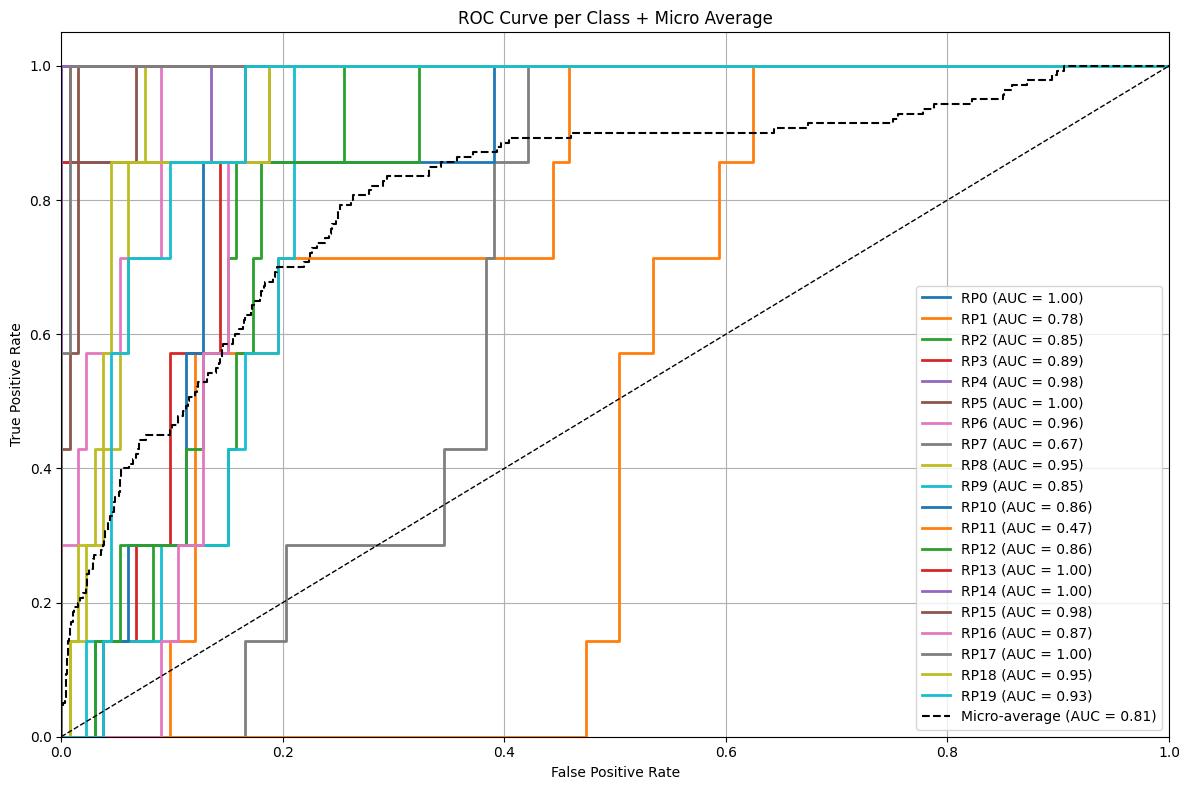

In [ ]:
# Binarisasi label untuk ROC (one-hot)
y_pred_prob = best_model_mlp.predict(X_test_transformed)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(Y_test_encoded, axis=1)
y_test_bin = label_binarize(y_true, classes=range(num_of_classes))  # shape: (n_samples, n_classes)

# ROC dan AUC per kelas
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Hitung macro average AUC
macro_auc_m = np.mean(list(roc_auc.values()))

# Hitung micro average AUC (gabungkan semua prediksi)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
micro_auc_m = auc(fpr["micro"], tpr["micro"])

# 🌈 Plot ROC curve untuk beberapa kelas (maks 20)
plt.figure(figsize=(12, 8))
for i in range(min(20, num_of_classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'RP{i} (AUC = {roc_auc[i]:.2f})')

# Tambahkan micro ROC
plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--',
         label=f'Micro-average (AUC = {micro_auc_m:.2f})')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class + Micro Average")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Print summary
print(f"📊 Macro Average AUC: {macro_auc_m:.4f}")
print(f"📊 Micro Average AUC: {micro_auc_m:.4f}")

# Simpan hasil
filename = 'ROC_MLP.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

# RBFKAN Real Data

In [ ]:
# Store history untuk akurasi dan loss
train_accuracies_rbfkan = []
val_accuracies_rbfkan = []
train_losses_rbfkan = []
val_losses_rbfkan = []
test_accuracies_rbf = []

best_model_rbfkan = None
best_acc_rbfkan = 0

for i in range(num_iterations):
    print(f"🔁 Iterasi ke-{i+1}")
    torch.manual_seed(i * seed_multiplier)
    np.random.seed(i * seed_multiplier)

    # Inisialisasi model
    model = RBFKAN(
        layers_hidden=[input_dim] + hidden_layers + [output_dim],
        use_base_update=True,
        base_activation=nn.SiLU(),
        spline_weight_init_scale=0.1
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr_rbfkan)
    criterion = nn.CrossEntropyLoss()

    # Simpan akurasi & loss per epoch (untuk satu iterasi)
    train_acc_epochs = []
    val_acc_epochs = []
    train_loss_epochs = []
    val_loss_epochs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_train += (preds == batch_y).sum().item()
            total_train += batch_y.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_loss_epochs.append(avg_train_loss)
        train_acc_epochs.append(train_accuracy)

        # Validasi
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct_val += (preds == val_y).sum().item()
                total_val += val_y.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_loss_epochs.append(avg_val_loss)
        val_acc_epochs.append(val_accuracy)

    # Simpan per-epoch hasil iterasi ini
    train_accuracies_rbfkan.append(train_acc_epochs)
    val_accuracies_rbfkan.append(val_acc_epochs)
    train_losses_rbfkan.append(train_loss_epochs)
    val_losses_rbfkan.append(val_loss_epochs)

    # Evaluasi akhir di test set
    model.eval()
    with torch.no_grad():
        outputs = model(features_test_tensor)
        preds = torch.argmax(outputs, dim=1)
        test_acc = accuracy_score(labels_test_tensor.numpy(), preds.numpy())
        test_accuracies_rbf.append(test_acc)

    print(f"✅ Val acc (last epoch): {val_accuracy:.4f}, Test acc: {test_acc:.4f}")
    if test_acc > best_acc_rbfkan:
        best_model_rbfkan = model
        best_acc_rbfkan = test_acc
    else:
        del model
        torch.cuda.empty_cache()

# Rata-rata per epoch dari semua iterasi
train_accuracies_rbfkan = np.mean(train_accuracies_rbfkan, axis=0)
val_accuracies_rbfkan = np.mean(val_accuracies_rbfkan, axis=0)
train_losses_rbfkan = np.mean(train_losses_rbfkan, axis=0)
val_losses_rbfkan = np.mean(val_losses_rbfkan, axis=0)

print("📊 Rata-rata akurasi uji RBFKAN:", np.mean(test_accuracies_rbf))
print("🎯 Akurasi terbaik RBFKAN:", best_acc_rbfkan)


🔁 Iterasi ke-1
✅ Val acc (last epoch): 0.3000, Test acc: 0.5143
📊 Rata-rata akurasi uji RBFKAN: 0.5142857142857142
🎯 Akurasi terbaik RBFKAN: 0.5142857142857142


📊 Macro Average AUC (RBFKAN): 0.9171
📊 Micro Average AUC (RBFKAN): 0.8830


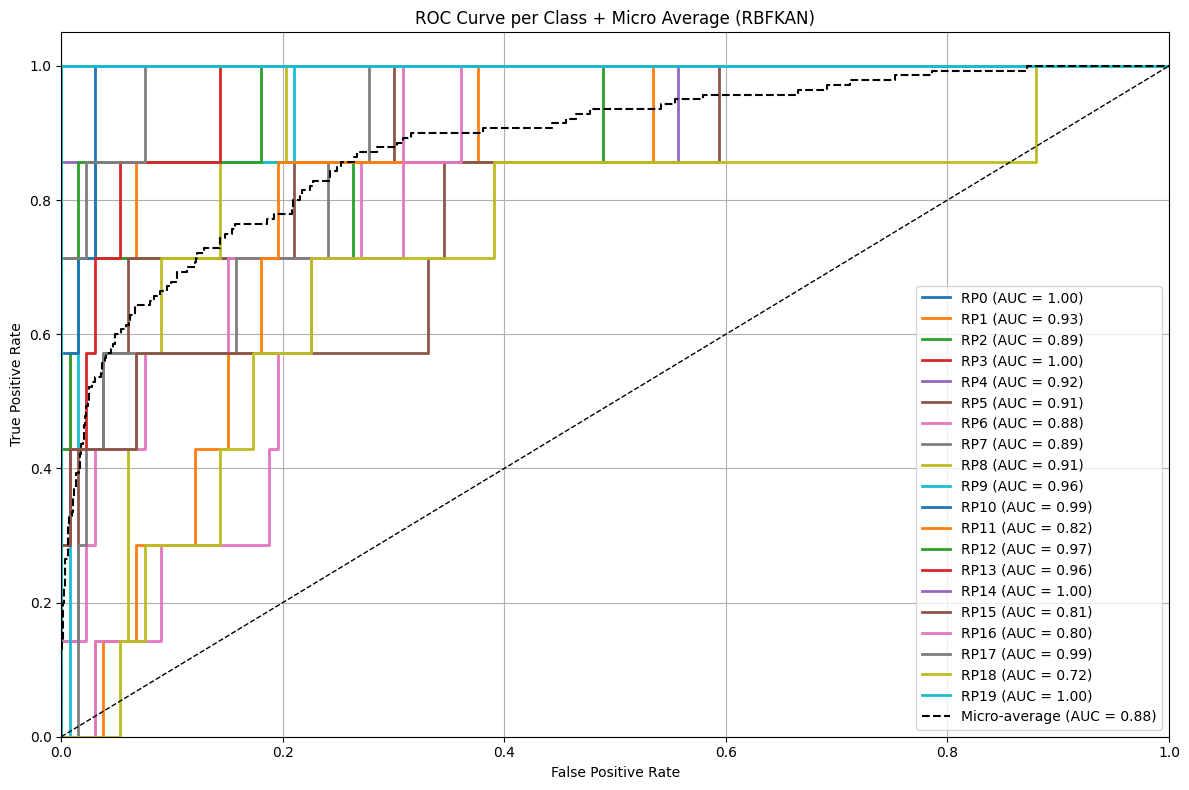

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import os

# Pastikan model dalam mode evaluasi
best_model_rbfkan.eval()

# Prediksi probabilitas (softmax)
with torch.no_grad():
    logits = best_model_rbfkan(features_test_tensor)
    y_pred_prob = F.softmax(logits, dim=1).numpy()
    y_true = labels_test_tensor.numpy()

# Binarisasi label untuk ROC (one-hot)
y_test_bin = label_binarize(y_true, classes=range(num_of_classes))  # shape: (n_samples, n_classes)

# ROC dan AUC per kelas
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Hitung macro average AUC
macro_auc_r = np.mean(list(roc_auc.values()))

# Hitung micro average AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
micro_auc_r = auc(fpr["micro"], tpr["micro"])

# 🌈 Plot ROC curve
plt.figure(figsize=(12, 8))
for i in range(min(20, num_of_classes)):  # Batasi maksimal 20 kelas
    plt.plot(fpr[i], tpr[i], lw=2, label=f'RP{i} (AUC = {roc_auc[i]:.2f})')

# Tambahkan micro average
plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--',
         label=f'Micro-average (AUC = {micro_auc_r:.2f})')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class + Micro Average (RBFKAN)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Print summary
print(f"📊 Macro Average AUC (RBFKAN): {macro_auc_r:.4f}")
print(f"📊 Micro Average AUC (RBFKAN): {micro_auc_r:.4f}")

# Simpan hasil
filename = 'ROC_RBF.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

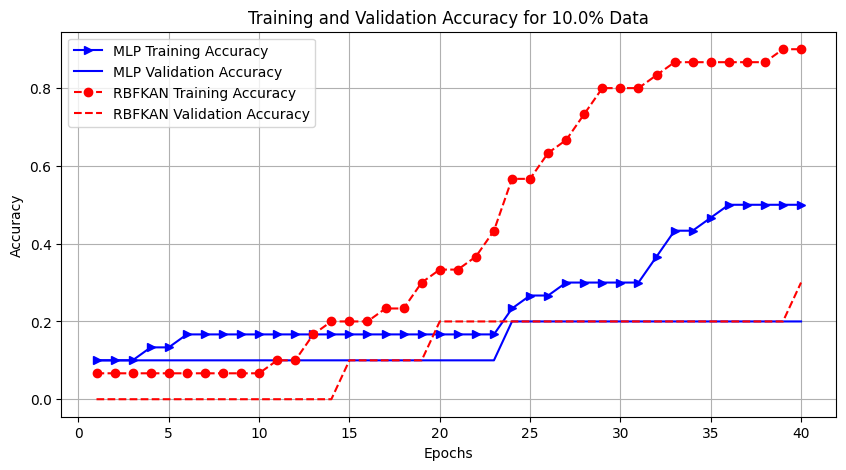

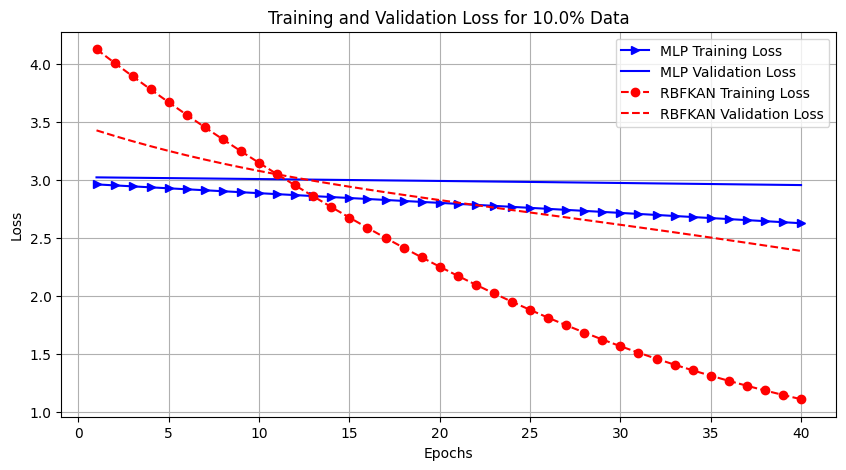

In [ ]:
# MLP metrics
trainacc = []
trainloss = []
valacc = []
valloss = []

for i in range(len(history)):
    trainacc.append(history[i].history['accuracy'])
    trainloss.append(history[i].history['loss'])
    valacc.append(history[i].history['val_accuracy'])
    valloss.append(history[i].history['val_loss'])

acc = np.mean(trainacc, axis=0)
val_acc = np.mean(valacc, axis=0)
loss = np.mean(trainloss, axis=0)
val_loss = np.mean(valloss, axis=0)
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'b>-', label='MLP Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='MLP Validation Accuracy')
plt.plot(epochs, train_accuracies_rbfkan, 'ro--', label='RBFKAN Training Accuracy')
plt.plot(epochs, val_accuracies_rbfkan, 'r--', label='RBFKAN Validation Accuracy')
plt.title('Training and Validation Accuracy for {}% Data'.format(fraction_of_data*100))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

filename = 'Pre-Accuracy.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b>-', label='MLP Training Loss')
plt.plot(epochs, val_loss, 'b-', label='MLP Validation Loss')
plt.plot(epochs, train_losses_rbfkan, 'ro--', label='RBFKAN Training Loss')
plt.plot(epochs, val_losses_rbfkan, 'r--', label='RBFKAN Validation Loss')
plt.title('Training and Validation Loss for {}% Data'.format(fraction_of_data*100))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

filename = 'Pre-Loss.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

# Generating Synthetic Data


In [ ]:
def build_generator():
    noise = Input(shape=(latent_dim,))
    x = Dense(256)(noise)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(np.prod(data_shape), activation='tanh')(x)
    gendata = Reshape(data_shape)(x)

    model = Model(noise, gendata)
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    return model

def build_discriminator():
    data = Input(shape=data_shape)
    x = Flatten()(data)
    x = Dense(512)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    validity = Dense(1, activation='sigmoid')(x)

    model = Model(data, validity)
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

    return model

In [ ]:
dis_loss = []
gen_loss = []
all_loss = []

def train_osgan(epochs, features, batch_size=64):
    valid = np.ones((batch_size, 1)) * 0.9  # Real label = 0.9, bukan 1.0
    fake = np.zeros((batch_size, 1)) * 0.1  # Fake label = 0.1, bukan 0.0

    # Optimizer untuk pembaruan bersamaan
    combined_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

    for epoch in range(epochs):
        idx = np.random.randint(0, features.shape[0], batch_size)
        real_data = features[idx]

        # Noise untuk generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        with tf.GradientTape() as tape:
            # Forward pass
            generated_data = generator(noise, training=True)
            real_output = discriminator(real_data, training=True)
            fake_output = discriminator(generated_data, training=True)

            # Loss Discriminator
            d_loss_real = tf.reduce_mean(valid * (real_output))
            d_loss_fake = tf.reduce_mean((1 - fake) * (fake_output))
            d_loss = d_loss_real + d_loss_fake

            # Loss Generator
            g_loss = d_loss_fake  # Simetris: gradien G berasal dari gradien D

            # Hitung gradien gabungan
            gradients = tape.gradient(d_loss, discriminator.trainable_variables + generator.trainable_variables)

            # Update parameter generator dan discriminator secara simultan
            combined_optimizer.apply_gradients(
              zip(gradients, discriminator.trainable_variables + generator.trainable_variables)
            )

            # Simpan loss untuk analisis
            dis_loss.append(d_loss.numpy())
            gen_loss.append(g_loss.numpy())
            all_loss.append(np.absolute(d_loss.numpy() - g_loss.numpy()))

        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, D Loss: {d_loss.numpy()}, G Loss: {g_loss.numpy()}")

In [ ]:
@tf.function
def train_step(features, batch_size, valid, fake):
    # Ambil batch acak dari real data
    idx = tf.random.uniform((batch_size,), 0, tf.shape(features)[0], dtype=tf.int32)
    real_data = tf.gather(features, idx)
    noise = tf.random.normal((batch_size, latent_dim))

    with tf.GradientTape() as tape:
        generated_data = generator(noise, training=True)
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)

        # Loss Discriminator
        d_loss_real = tf.reduce_mean(valid * (real_output))
        d_loss_fake = tf.reduce_mean((1 - fake) * (fake_output))
        d_loss = d_loss_real + d_loss_fake
        g_loss = d_loss_fake

        gradients = tape.gradient(d_loss, discriminator.trainable_variables + generator.trainable_variables)
        combined_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables + generator.trainable_variables))

    return d_loss, g_loss

def train_osgan(epochs, features, batch_size=64):
    # Konversi fitur ke tensor float32 agar jalan di GPU
    features = tf.convert_to_tensor(features, dtype=tf.float32)

    # Label real dan fake (smooth)
    valid = tf.ones((batch_size, 1), dtype=tf.float32) * 0.9
    fake = tf.zeros((batch_size, 1), dtype=tf.float32) * 0.1

    # Optimizer untuk training simultan
    global combined_optimizer
    combined_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

    for epoch in range(epochs):
        d_loss, g_loss = train_step(features, batch_size, valid, fake)

        # Simpan loss
        dis_loss.append(d_loss.numpy())
        gen_loss.append(g_loss.numpy())
        all_loss.append(np.abs(d_loss.numpy() - g_loss.numpy()))

        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, D Loss: {d_loss.numpy():.4f}, G Loss: {g_loss.numpy():.4f}")

In [ ]:
"""**Training GAN**"""

gen_data = []

for i in tqdm(range(num_of_classes)):
    # Bangun discriminator dan generator
    discriminator = build_discriminator()
    generator = build_generator()

    # Transformasi data
    minimaxscaler = MinMaxScaler((-1, 1))
    Z_train_transformed = minimaxscaler.fit_transform(Z_train[i])
    Z_train_transformed = np.expand_dims(Z_train_transformed, axis=2)

    # Latih menggunakan OSGAN
    train_osgan(
        epochs=gan_epochs,
        features=Z_train_transformed,
        batch_size=64
    )

    # Generate data baru
    noise = np.random.normal(0, 1, (data_to_gen, latent_dim))
    gen_data_temp = generator.predict(noise)
    gen_data_temp = np.asarray(gen_data_temp, dtype=np.float32)
    gen_data_temp = np.squeeze(gen_data_temp)
    gen_data_temp = minimaxscaler.inverse_transform(gen_data_temp)

    gen_data.append(gen_data_temp)

    # Bersihkan sesi untuk setiap kelas
    clear_session()
    del discriminator
    del generator

gen_data = np.asarray(gen_data, dtype=np.float32)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0, D Loss: 0.9372, G Loss: 0.5022
Epoch: 10, D Loss: 0.7855, G Loss: 0.4351
Epoch: 20, D Loss: 0.6338, G Loss: 0.3642
Epoch: 30, D Loss: 0.4832, G Loss: 0.2864
Epoch: 40, D Loss: 0.3561, G Loss: 0.2120
Epoch: 50, D Loss: 0.2602, G Loss: 0.1602
Epoch: 60, D Loss: 0.1885, G Loss: 0.1181
Epoch: 70, D Loss: 0.1373, G Loss: 0.0857
Epoch: 80, D Loss: 0.1130, G Loss: 0.0747
Epoch: 90, D Loss: 0.0767, G Loss: 0.0476
Epoch: 100, D Loss: 0.0655, G Loss: 0.0424
Epoch: 110, D Loss: 0.0563, G Loss: 0.0382
Epoch: 120, D Loss: 0.0417, G Loss: 0.0271
Epoch: 130, D Loss: 0.0406, G Loss: 0.0286
Epoch: 140, D Loss: 0.0326, G Loss: 0.0226
Epoch: 150, D Loss: 0.0261, G Loss: 0.0177
Epoch: 160, D Loss: 0.0247, G Loss: 0.0176
Epoch: 170, D Loss: 0.0185, G Loss: 0.0123
Epoch: 180, D Loss: 0.0196, G Loss: 0.0142
Epoch: 190, D Loss: 0.0176, G Loss: 0.0129
Epoch: 200, D Loss: 0.0147, G Loss: 0.0106
Epoch: 210, D Loss: 0.0134, G Loss: 0.0097
Epoch: 220, D Loss: 0.0120, G Loss: 0.0087
Epoch: 230, D Loss: 0.

  5%|▌         | 1/20 [00:09<03:07,  9.85s/it]

Epoch: 0, D Loss: 0.0012, G Loss: 0.0003
Epoch: 10, D Loss: 0.0013, G Loss: 0.0003
Epoch: 20, D Loss: 0.0012, G Loss: 0.0003
Epoch: 30, D Loss: 0.0010, G Loss: 0.0003
Epoch: 40, D Loss: 0.0010, G Loss: 0.0002
Epoch: 50, D Loss: 0.0009, G Loss: 0.0002
Epoch: 60, D Loss: 0.0008, G Loss: 0.0002
Epoch: 70, D Loss: 0.0008, G Loss: 0.0002
Epoch: 80, D Loss: 0.0008, G Loss: 0.0002
Epoch: 90, D Loss: 0.0006, G Loss: 0.0002
Epoch: 100, D Loss: 0.0007, G Loss: 0.0001
Epoch: 110, D Loss: 0.0008, G Loss: 0.0003
Epoch: 120, D Loss: 0.0007, G Loss: 0.0002
Epoch: 130, D Loss: 0.0006, G Loss: 0.0002
Epoch: 140, D Loss: 0.0006, G Loss: 0.0002
Epoch: 150, D Loss: 0.0005, G Loss: 0.0001
Epoch: 160, D Loss: 0.0005, G Loss: 0.0002
Epoch: 170, D Loss: 0.0005, G Loss: 0.0001
Epoch: 180, D Loss: 0.0006, G Loss: 0.0003
Epoch: 190, D Loss: 0.0005, G Loss: 0.0002
Epoch: 200, D Loss: 0.0005, G Loss: 0.0002
Epoch: 210, D Loss: 0.0005, G Loss: 0.0002
Epoch: 220, D Loss: 0.0005, G Loss: 0.0002
Epoch: 230, D Loss: 0.

 10%|█         | 2/20 [00:16<02:22,  7.89s/it]

Epoch: 0, D Loss: 0.0003, G Loss: 0.0000
Epoch: 10, D Loss: 0.0003, G Loss: 0.0001
Epoch: 20, D Loss: 0.0003, G Loss: 0.0001
Epoch: 30, D Loss: 0.0002, G Loss: 0.0000
Epoch: 40, D Loss: 0.0002, G Loss: 0.0000
Epoch: 50, D Loss: 0.0002, G Loss: 0.0000
Epoch: 60, D Loss: 0.0002, G Loss: 0.0000
Epoch: 70, D Loss: 0.0002, G Loss: 0.0000
Epoch: 80, D Loss: 0.0002, G Loss: 0.0000
Epoch: 90, D Loss: 0.0002, G Loss: 0.0000
Epoch: 100, D Loss: 0.0002, G Loss: 0.0000
Epoch: 110, D Loss: 0.0002, G Loss: 0.0000
Epoch: 120, D Loss: 0.0002, G Loss: 0.0000
Epoch: 130, D Loss: 0.0001, G Loss: 0.0000
Epoch: 140, D Loss: 0.0001, G Loss: 0.0000
Epoch: 150, D Loss: 0.0001, G Loss: 0.0000
Epoch: 160, D Loss: 0.0001, G Loss: 0.0000
Epoch: 170, D Loss: 0.0001, G Loss: 0.0000
Epoch: 180, D Loss: 0.0002, G Loss: 0.0000
Epoch: 190, D Loss: 0.0001, G Loss: 0.0000
Epoch: 200, D Loss: 0.0001, G Loss: 0.0000
Epoch: 210, D Loss: 0.0001, G Loss: 0.0000
Epoch: 220, D Loss: 0.0001, G Loss: 0.0000
Epoch: 230, D Loss: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 15%|█▌        | 3/20 [00:22<02:03,  7.28s/it]

Epoch: 0, D Loss: 0.0001, G Loss: 0.0000
Epoch: 10, D Loss: 0.0001, G Loss: 0.0000
Epoch: 20, D Loss: 0.0001, G Loss: 0.0000
Epoch: 30, D Loss: 0.0001, G Loss: 0.0000
Epoch: 40, D Loss: 0.0001, G Loss: 0.0000
Epoch: 50, D Loss: 0.0001, G Loss: 0.0000
Epoch: 60, D Loss: 0.0001, G Loss: 0.0000
Epoch: 70, D Loss: 0.0001, G Loss: 0.0000
Epoch: 80, D Loss: 0.0001, G Loss: 0.0000
Epoch: 90, D Loss: 0.0001, G Loss: 0.0000
Epoch: 100, D Loss: 0.0001, G Loss: 0.0000
Epoch: 110, D Loss: 0.0001, G Loss: 0.0000
Epoch: 120, D Loss: 0.0001, G Loss: 0.0000
Epoch: 130, D Loss: 0.0001, G Loss: 0.0000
Epoch: 140, D Loss: 0.0001, G Loss: 0.0000
Epoch: 150, D Loss: 0.0000, G Loss: 0.0000
Epoch: 160, D Loss: 0.0000, G Loss: 0.0000
Epoch: 170, D Loss: 0.0000, G Loss: 0.0000
Epoch: 180, D Loss: 0.0001, G Loss: 0.0000
Epoch: 190, D Loss: 0.0000, G Loss: 0.0000
Epoch: 200, D Loss: 0.0000, G Loss: 0.0000
Epoch: 210, D Loss: 0.0001, G Loss: 0.0000
Epoch: 220, D Loss: 0.0000, G Loss: 0.0000
Epoch: 230, D Loss: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 20%|██        | 4/20 [00:29<01:51,  6.97s/it]

Epoch: 0, D Loss: 0.0000, G Loss: 0.0000
Epoch: 10, D Loss: 0.0001, G Loss: 0.0000
Epoch: 20, D Loss: 0.0000, G Loss: 0.0000
Epoch: 30, D Loss: 0.0000, G Loss: 0.0000
Epoch: 40, D Loss: 0.0000, G Loss: 0.0000
Epoch: 50, D Loss: 0.0000, G Loss: 0.0000
Epoch: 60, D Loss: 0.0000, G Loss: 0.0000
Epoch: 70, D Loss: 0.0000, G Loss: 0.0000
Epoch: 80, D Loss: 0.0000, G Loss: 0.0000
Epoch: 90, D Loss: 0.0000, G Loss: 0.0000
Epoch: 100, D Loss: 0.0000, G Loss: 0.0000
Epoch: 110, D Loss: 0.0000, G Loss: 0.0000
Epoch: 120, D Loss: 0.0000, G Loss: 0.0000
Epoch: 130, D Loss: 0.0000, G Loss: 0.0000
Epoch: 140, D Loss: 0.0000, G Loss: 0.0000
Epoch: 150, D Loss: 0.0000, G Loss: 0.0000
Epoch: 160, D Loss: 0.0000, G Loss: 0.0000
Epoch: 170, D Loss: 0.0000, G Loss: 0.0000
Epoch: 180, D Loss: 0.0000, G Loss: 0.0000
Epoch: 190, D Loss: 0.0000, G Loss: 0.0000
Epoch: 200, D Loss: 0.0000, G Loss: 0.0000
Epoch: 210, D Loss: 0.0000, G Loss: 0.0000
Epoch: 220, D Loss: 0.0000, G Loss: 0.0000
Epoch: 230, D Loss: 0.

 25%|██▌       | 5/20 [00:35<01:42,  6.81s/it]

Epoch: 0, D Loss: 0.0000, G Loss: 0.0000
Epoch: 10, D Loss: 0.0000, G Loss: 0.0000
Epoch: 20, D Loss: 0.0000, G Loss: 0.0000
Epoch: 30, D Loss: 0.0000, G Loss: 0.0000
Epoch: 40, D Loss: 0.0000, G Loss: 0.0000
Epoch: 50, D Loss: 0.0000, G Loss: 0.0000
Epoch: 60, D Loss: 0.0000, G Loss: 0.0000
Epoch: 70, D Loss: 0.0000, G Loss: 0.0000
Epoch: 80, D Loss: 0.0000, G Loss: 0.0000
Epoch: 90, D Loss: 0.0000, G Loss: 0.0000
Epoch: 100, D Loss: 0.0000, G Loss: 0.0000
Epoch: 110, D Loss: 0.0000, G Loss: 0.0000
Epoch: 120, D Loss: 0.0000, G Loss: 0.0000
Epoch: 130, D Loss: 0.0000, G Loss: 0.0000
Epoch: 140, D Loss: 0.0000, G Loss: 0.0000
Epoch: 150, D Loss: 0.0000, G Loss: 0.0000
Epoch: 160, D Loss: 0.0000, G Loss: 0.0000
Epoch: 170, D Loss: 0.0000, G Loss: 0.0000
Epoch: 180, D Loss: 0.0000, G Loss: 0.0000
Epoch: 190, D Loss: 0.0000, G Loss: 0.0000
Epoch: 200, D Loss: 0.0000, G Loss: 0.0000
Epoch: 210, D Loss: 0.0000, G Loss: 0.0000
Epoch: 220, D Loss: 0.0000, G Loss: 0.0000
Epoch: 230, D Loss: 0.

 30%|███       | 6/20 [00:42<01:33,  6.70s/it]

Epoch: 0, D Loss: 0.0000, G Loss: 0.0000
Epoch: 10, D Loss: 0.0000, G Loss: 0.0000
Epoch: 20, D Loss: 0.0000, G Loss: 0.0000
Epoch: 30, D Loss: 0.0000, G Loss: 0.0000
Epoch: 40, D Loss: 0.0000, G Loss: 0.0000
Epoch: 50, D Loss: 0.0000, G Loss: 0.0000
Epoch: 60, D Loss: 0.0000, G Loss: 0.0000
Epoch: 70, D Loss: 0.0000, G Loss: 0.0000
Epoch: 80, D Loss: 0.0000, G Loss: 0.0000
Epoch: 90, D Loss: 0.0000, G Loss: 0.0000
Epoch: 100, D Loss: 0.0000, G Loss: 0.0000
Epoch: 110, D Loss: 0.0000, G Loss: 0.0000
Epoch: 120, D Loss: 0.0000, G Loss: 0.0000
Epoch: 130, D Loss: 0.0000, G Loss: 0.0000
Epoch: 140, D Loss: 0.0000, G Loss: 0.0000
Epoch: 150, D Loss: 0.0000, G Loss: 0.0000
Epoch: 160, D Loss: 0.0000, G Loss: 0.0000
Epoch: 170, D Loss: 0.0000, G Loss: 0.0000
Epoch: 180, D Loss: 0.0000, G Loss: 0.0000
Epoch: 190, D Loss: 0.0000, G Loss: 0.0000
Epoch: 200, D Loss: 0.0000, G Loss: 0.0000
Epoch: 210, D Loss: 0.0000, G Loss: 0.0000
Epoch: 220, D Loss: 0.0000, G Loss: 0.0000
Epoch: 230, D Loss: 0.

 35%|███▌      | 7/20 [00:48<01:26,  6.63s/it]

Epoch: 0, D Loss: 0.0000, G Loss: 0.0000
Epoch: 10, D Loss: 0.0000, G Loss: 0.0000
Epoch: 20, D Loss: 0.0000, G Loss: 0.0000
Epoch: 30, D Loss: 0.0000, G Loss: 0.0000
Epoch: 40, D Loss: 0.0000, G Loss: 0.0000
Epoch: 50, D Loss: 0.0000, G Loss: 0.0000
Epoch: 60, D Loss: 0.0000, G Loss: 0.0000
Epoch: 70, D Loss: 0.0000, G Loss: 0.0000
Epoch: 80, D Loss: 0.0000, G Loss: 0.0000
Epoch: 90, D Loss: 0.0000, G Loss: 0.0000
Epoch: 100, D Loss: 0.0000, G Loss: 0.0000
Epoch: 110, D Loss: 0.0000, G Loss: 0.0000
Epoch: 120, D Loss: 0.0000, G Loss: 0.0000
Epoch: 130, D Loss: 0.0000, G Loss: 0.0000
Epoch: 140, D Loss: 0.0000, G Loss: 0.0000
Epoch: 150, D Loss: 0.0000, G Loss: 0.0000
Epoch: 160, D Loss: 0.0000, G Loss: 0.0000
Epoch: 170, D Loss: 0.0000, G Loss: 0.0000
Epoch: 180, D Loss: 0.0000, G Loss: 0.0000
Epoch: 190, D Loss: 0.0000, G Loss: 0.0000
Epoch: 200, D Loss: 0.0000, G Loss: 0.0000
Epoch: 210, D Loss: 0.0000, G Loss: 0.0000
Epoch: 220, D Loss: 0.0000, G Loss: 0.0000
Epoch: 230, D Loss: 0.

 40%|████      | 8/20 [00:55<01:19,  6.59s/it]

Epoch: 0, D Loss: 0.0000, G Loss: 0.0000
Epoch: 10, D Loss: 0.0000, G Loss: 0.0000
Epoch: 20, D Loss: 0.0000, G Loss: 0.0000
Epoch: 30, D Loss: 0.0000, G Loss: 0.0000
Epoch: 40, D Loss: 0.0000, G Loss: 0.0000
Epoch: 50, D Loss: 0.0000, G Loss: 0.0000
Epoch: 60, D Loss: 0.0000, G Loss: 0.0000
Epoch: 70, D Loss: 0.0000, G Loss: 0.0000
Epoch: 80, D Loss: 0.0000, G Loss: 0.0000
Epoch: 90, D Loss: 0.0000, G Loss: 0.0000
Epoch: 100, D Loss: 0.0000, G Loss: 0.0000
Epoch: 110, D Loss: 0.0000, G Loss: 0.0000
Epoch: 120, D Loss: 0.0000, G Loss: 0.0000
Epoch: 130, D Loss: 0.0000, G Loss: 0.0000
Epoch: 140, D Loss: 0.0000, G Loss: 0.0000
Epoch: 150, D Loss: 0.0000, G Loss: 0.0000
Epoch: 160, D Loss: 0.0000, G Loss: 0.0000
Epoch: 170, D Loss: 0.0000, G Loss: 0.0000
Epoch: 180, D Loss: 0.0000, G Loss: 0.0000
Epoch: 190, D Loss: 0.0000, G Loss: 0.0000
Epoch: 200, D Loss: 0.0000, G Loss: 0.0000
Epoch: 210, D Loss: 0.0000, G Loss: 0.0000
Epoch: 220, D Loss: 0.0000, G Loss: 0.0000
Epoch: 230, D Loss: 0.

 45%|████▌     | 9/20 [01:01<01:12,  6.56s/it]

Epoch: 0, D Loss: 0.0000, G Loss: 0.0000
Epoch: 10, D Loss: 0.0000, G Loss: 0.0000
Epoch: 20, D Loss: 0.0000, G Loss: 0.0000
Epoch: 30, D Loss: 0.0000, G Loss: 0.0000
Epoch: 40, D Loss: 0.0000, G Loss: 0.0000
Epoch: 50, D Loss: 0.0000, G Loss: 0.0000
Epoch: 60, D Loss: 0.0000, G Loss: 0.0000
Epoch: 70, D Loss: 0.0000, G Loss: 0.0000
Epoch: 80, D Loss: 0.0000, G Loss: 0.0000
Epoch: 90, D Loss: 0.0000, G Loss: 0.0000
Epoch: 100, D Loss: 0.0000, G Loss: 0.0000
Epoch: 110, D Loss: 0.0000, G Loss: 0.0000
Epoch: 120, D Loss: 0.0000, G Loss: 0.0000
Epoch: 130, D Loss: 0.0000, G Loss: 0.0000
Epoch: 140, D Loss: 0.0000, G Loss: 0.0000
Epoch: 150, D Loss: 0.0000, G Loss: 0.0000
Epoch: 160, D Loss: 0.0000, G Loss: 0.0000
Epoch: 170, D Loss: 0.0000, G Loss: 0.0000
Epoch: 180, D Loss: 0.0000, G Loss: 0.0000
Epoch: 190, D Loss: 0.0000, G Loss: 0.0000
Epoch: 200, D Loss: 0.0000, G Loss: 0.0000
Epoch: 210, D Loss: 0.0000, G Loss: 0.0000
Epoch: 220, D Loss: 0.0000, G Loss: 0.0000
Epoch: 230, D Loss: 0.

 50%|█████     | 10/20 [01:08<01:05,  6.54s/it]

Epoch: 0, D Loss: 0.0000, G Loss: 0.0000
Epoch: 10, D Loss: 0.0000, G Loss: 0.0000
Epoch: 20, D Loss: 0.0000, G Loss: 0.0000
Epoch: 30, D Loss: 0.0000, G Loss: 0.0000
Epoch: 40, D Loss: 0.0000, G Loss: 0.0000
Epoch: 50, D Loss: 0.0000, G Loss: 0.0000
Epoch: 60, D Loss: 0.0000, G Loss: 0.0000
Epoch: 70, D Loss: 0.0000, G Loss: 0.0000
Epoch: 80, D Loss: 0.0000, G Loss: 0.0000
Epoch: 90, D Loss: 0.0000, G Loss: 0.0000
Epoch: 100, D Loss: 0.0000, G Loss: 0.0000
Epoch: 110, D Loss: 0.0000, G Loss: 0.0000
Epoch: 120, D Loss: 0.0000, G Loss: 0.0000
Epoch: 130, D Loss: 0.0000, G Loss: 0.0000
Epoch: 140, D Loss: 0.0000, G Loss: 0.0000
Epoch: 150, D Loss: 0.0000, G Loss: 0.0000
Epoch: 160, D Loss: 0.0000, G Loss: 0.0000
Epoch: 170, D Loss: 0.0000, G Loss: 0.0000
Epoch: 180, D Loss: 0.0000, G Loss: 0.0000
Epoch: 190, D Loss: 0.0000, G Loss: 0.0000
Epoch: 200, D Loss: 0.0000, G Loss: 0.0000
Epoch: 210, D Loss: 0.0000, G Loss: 0.0000
Epoch: 220, D Loss: 0.0000, G Loss: 0.0000
Epoch: 230, D Loss: 0.

 55%|█████▌    | 11/20 [01:14<00:58,  6.51s/it]

Epoch: 0, D Loss: 0.0000, G Loss: 0.0000
Epoch: 10, D Loss: 0.0000, G Loss: 0.0000
Epoch: 20, D Loss: 0.0000, G Loss: 0.0000
Epoch: 30, D Loss: 0.0000, G Loss: 0.0000
Epoch: 40, D Loss: 0.0000, G Loss: 0.0000
Epoch: 50, D Loss: 0.0000, G Loss: 0.0000
Epoch: 60, D Loss: 0.0000, G Loss: 0.0000
Epoch: 70, D Loss: 0.0000, G Loss: 0.0000
Epoch: 80, D Loss: 0.0000, G Loss: 0.0000
Epoch: 90, D Loss: 0.0000, G Loss: 0.0000
Epoch: 100, D Loss: 0.0000, G Loss: 0.0000
Epoch: 110, D Loss: 0.0000, G Loss: 0.0000
Epoch: 120, D Loss: 0.0000, G Loss: 0.0000
Epoch: 130, D Loss: 0.0000, G Loss: 0.0000
Epoch: 140, D Loss: 0.0000, G Loss: 0.0000
Epoch: 150, D Loss: 0.0000, G Loss: 0.0000
Epoch: 160, D Loss: 0.0000, G Loss: 0.0000
Epoch: 170, D Loss: 0.0000, G Loss: 0.0000
Epoch: 180, D Loss: 0.0000, G Loss: 0.0000
Epoch: 190, D Loss: 0.0000, G Loss: 0.0000
Epoch: 200, D Loss: 0.0000, G Loss: 0.0000
Epoch: 210, D Loss: 0.0000, G Loss: 0.0000
Epoch: 220, D Loss: 0.0000, G Loss: 0.0000
Epoch: 230, D Loss: 0.

 60%|██████    | 12/20 [01:21<00:51,  6.49s/it]

Epoch: 0, D Loss: 0.0000, G Loss: 0.0000
Epoch: 10, D Loss: 0.0000, G Loss: 0.0000
Epoch: 20, D Loss: 0.0000, G Loss: 0.0000
Epoch: 30, D Loss: 0.0000, G Loss: 0.0000
Epoch: 40, D Loss: 0.0000, G Loss: 0.0000
Epoch: 50, D Loss: 0.0000, G Loss: 0.0000
Epoch: 60, D Loss: 0.0000, G Loss: 0.0000
Epoch: 70, D Loss: 0.0000, G Loss: 0.0000
Epoch: 80, D Loss: 0.0000, G Loss: 0.0000
Epoch: 90, D Loss: 0.0000, G Loss: 0.0000
Epoch: 100, D Loss: 0.0000, G Loss: 0.0000
Epoch: 110, D Loss: 0.0000, G Loss: 0.0000
Epoch: 120, D Loss: 0.0000, G Loss: 0.0000
Epoch: 130, D Loss: 0.0000, G Loss: 0.0000
Epoch: 140, D Loss: 0.0000, G Loss: 0.0000
Epoch: 150, D Loss: 0.0000, G Loss: 0.0000
Epoch: 160, D Loss: 0.0000, G Loss: 0.0000
Epoch: 170, D Loss: 0.0000, G Loss: 0.0000
Epoch: 180, D Loss: 0.0000, G Loss: 0.0000
Epoch: 190, D Loss: 0.0000, G Loss: 0.0000
Epoch: 200, D Loss: 0.0000, G Loss: 0.0000
Epoch: 210, D Loss: 0.0000, G Loss: 0.0000
Epoch: 220, D Loss: 0.0000, G Loss: 0.0000
Epoch: 230, D Loss: 0.

 65%|██████▌   | 13/20 [01:27<00:45,  6.45s/it]

Epoch: 0, D Loss: 0.0000, G Loss: 0.0000
Epoch: 10, D Loss: 0.0000, G Loss: 0.0000
Epoch: 20, D Loss: 0.0000, G Loss: 0.0000
Epoch: 30, D Loss: 0.0000, G Loss: 0.0000
Epoch: 40, D Loss: 0.0000, G Loss: 0.0000
Epoch: 50, D Loss: 0.0000, G Loss: 0.0000
Epoch: 60, D Loss: 0.0000, G Loss: 0.0000
Epoch: 70, D Loss: 0.0000, G Loss: 0.0000
Epoch: 80, D Loss: 0.0000, G Loss: 0.0000
Epoch: 90, D Loss: 0.0000, G Loss: 0.0000
Epoch: 100, D Loss: 0.0000, G Loss: 0.0000
Epoch: 110, D Loss: 0.0000, G Loss: 0.0000
Epoch: 120, D Loss: 0.0000, G Loss: 0.0000
Epoch: 130, D Loss: 0.0000, G Loss: 0.0000
Epoch: 140, D Loss: 0.0000, G Loss: 0.0000
Epoch: 150, D Loss: 0.0000, G Loss: 0.0000
Epoch: 160, D Loss: 0.0000, G Loss: 0.0000
Epoch: 170, D Loss: 0.0000, G Loss: 0.0000
Epoch: 180, D Loss: 0.0000, G Loss: 0.0000
Epoch: 190, D Loss: 0.0000, G Loss: 0.0000
Epoch: 200, D Loss: 0.0000, G Loss: 0.0000
Epoch: 210, D Loss: 0.0000, G Loss: 0.0000
Epoch: 220, D Loss: 0.0000, G Loss: 0.0000
Epoch: 230, D Loss: 0.

 70%|███████   | 14/20 [01:34<00:38,  6.43s/it]

Epoch: 0, D Loss: 0.0000, G Loss: 0.0000
Epoch: 10, D Loss: 0.0000, G Loss: 0.0000
Epoch: 20, D Loss: 0.0000, G Loss: 0.0000
Epoch: 30, D Loss: 0.0000, G Loss: 0.0000
Epoch: 40, D Loss: 0.0000, G Loss: 0.0000
Epoch: 50, D Loss: 0.0000, G Loss: 0.0000
Epoch: 60, D Loss: 0.0000, G Loss: 0.0000
Epoch: 70, D Loss: 0.0000, G Loss: 0.0000
Epoch: 80, D Loss: 0.0000, G Loss: 0.0000
Epoch: 90, D Loss: 0.0000, G Loss: 0.0000
Epoch: 100, D Loss: 0.0000, G Loss: 0.0000
Epoch: 110, D Loss: 0.0000, G Loss: 0.0000
Epoch: 120, D Loss: 0.0000, G Loss: 0.0000
Epoch: 130, D Loss: 0.0000, G Loss: 0.0000
Epoch: 140, D Loss: 0.0000, G Loss: 0.0000
Epoch: 150, D Loss: 0.0000, G Loss: 0.0000
Epoch: 160, D Loss: 0.0000, G Loss: 0.0000
Epoch: 170, D Loss: 0.0000, G Loss: 0.0000
Epoch: 180, D Loss: 0.0000, G Loss: 0.0000
Epoch: 190, D Loss: 0.0000, G Loss: 0.0000
Epoch: 200, D Loss: 0.0000, G Loss: 0.0000
Epoch: 210, D Loss: 0.0000, G Loss: 0.0000
Epoch: 220, D Loss: 0.0000, G Loss: 0.0000
Epoch: 230, D Loss: 0.

 75%|███████▌  | 15/20 [01:40<00:32,  6.42s/it]

Epoch: 0, D Loss: 0.0000, G Loss: 0.0000
Epoch: 10, D Loss: 0.0000, G Loss: 0.0000
Epoch: 20, D Loss: 0.0000, G Loss: 0.0000
Epoch: 30, D Loss: 0.0000, G Loss: 0.0000
Epoch: 40, D Loss: 0.0000, G Loss: 0.0000
Epoch: 50, D Loss: 0.0000, G Loss: 0.0000
Epoch: 60, D Loss: 0.0000, G Loss: 0.0000
Epoch: 70, D Loss: 0.0000, G Loss: 0.0000
Epoch: 80, D Loss: 0.0000, G Loss: 0.0000
Epoch: 90, D Loss: 0.0000, G Loss: 0.0000
Epoch: 100, D Loss: 0.0000, G Loss: 0.0000
Epoch: 110, D Loss: 0.0000, G Loss: 0.0000
Epoch: 120, D Loss: 0.0000, G Loss: 0.0000
Epoch: 130, D Loss: 0.0000, G Loss: 0.0000
Epoch: 140, D Loss: 0.0000, G Loss: 0.0000
Epoch: 150, D Loss: 0.0000, G Loss: 0.0000
Epoch: 160, D Loss: 0.0000, G Loss: 0.0000
Epoch: 170, D Loss: 0.0000, G Loss: 0.0000
Epoch: 180, D Loss: 0.0000, G Loss: 0.0000
Epoch: 190, D Loss: 0.0000, G Loss: 0.0000
Epoch: 200, D Loss: 0.0000, G Loss: 0.0000
Epoch: 210, D Loss: 0.0000, G Loss: 0.0000
Epoch: 220, D Loss: 0.0000, G Loss: 0.0000
Epoch: 230, D Loss: 0.

 80%|████████  | 16/20 [01:46<00:25,  6.43s/it]

Epoch: 0, D Loss: 0.0000, G Loss: 0.0000
Epoch: 10, D Loss: 0.0000, G Loss: 0.0000
Epoch: 20, D Loss: 0.0000, G Loss: 0.0000
Epoch: 30, D Loss: 0.0000, G Loss: 0.0000
Epoch: 40, D Loss: 0.0000, G Loss: 0.0000
Epoch: 50, D Loss: 0.0000, G Loss: 0.0000
Epoch: 60, D Loss: 0.0000, G Loss: 0.0000
Epoch: 70, D Loss: 0.0000, G Loss: 0.0000
Epoch: 80, D Loss: 0.0000, G Loss: 0.0000
Epoch: 90, D Loss: 0.0000, G Loss: 0.0000
Epoch: 100, D Loss: 0.0000, G Loss: 0.0000
Epoch: 110, D Loss: 0.0000, G Loss: 0.0000
Epoch: 120, D Loss: 0.0000, G Loss: 0.0000
Epoch: 130, D Loss: 0.0000, G Loss: 0.0000
Epoch: 140, D Loss: 0.0000, G Loss: 0.0000
Epoch: 150, D Loss: 0.0000, G Loss: 0.0000
Epoch: 160, D Loss: 0.0000, G Loss: 0.0000
Epoch: 170, D Loss: 0.0000, G Loss: 0.0000
Epoch: 180, D Loss: 0.0000, G Loss: 0.0000
Epoch: 190, D Loss: 0.0000, G Loss: 0.0000
Epoch: 200, D Loss: 0.0000, G Loss: 0.0000
Epoch: 210, D Loss: 0.0000, G Loss: 0.0000
Epoch: 220, D Loss: 0.0000, G Loss: 0.0000
Epoch: 230, D Loss: 0.

 85%|████████▌ | 17/20 [01:53<00:19,  6.41s/it]

Epoch: 0, D Loss: 0.0000, G Loss: 0.0000
Epoch: 10, D Loss: 0.0000, G Loss: 0.0000
Epoch: 20, D Loss: 0.0000, G Loss: 0.0000
Epoch: 30, D Loss: 0.0000, G Loss: 0.0000
Epoch: 40, D Loss: 0.0000, G Loss: 0.0000
Epoch: 50, D Loss: 0.0000, G Loss: 0.0000
Epoch: 60, D Loss: 0.0000, G Loss: 0.0000
Epoch: 70, D Loss: 0.0000, G Loss: 0.0000
Epoch: 80, D Loss: 0.0000, G Loss: 0.0000
Epoch: 90, D Loss: 0.0000, G Loss: 0.0000
Epoch: 100, D Loss: 0.0000, G Loss: 0.0000
Epoch: 110, D Loss: 0.0000, G Loss: 0.0000
Epoch: 120, D Loss: 0.0000, G Loss: 0.0000
Epoch: 130, D Loss: 0.0000, G Loss: 0.0000
Epoch: 140, D Loss: 0.0000, G Loss: 0.0000
Epoch: 150, D Loss: 0.0000, G Loss: 0.0000
Epoch: 160, D Loss: 0.0000, G Loss: 0.0000
Epoch: 170, D Loss: 0.0000, G Loss: 0.0000
Epoch: 180, D Loss: 0.0000, G Loss: 0.0000
Epoch: 190, D Loss: 0.0000, G Loss: 0.0000
Epoch: 200, D Loss: 0.0000, G Loss: 0.0000
Epoch: 210, D Loss: 0.0000, G Loss: 0.0000
Epoch: 220, D Loss: 0.0000, G Loss: 0.0000
Epoch: 230, D Loss: 0.

 90%|█████████ | 18/20 [01:59<00:12,  6.40s/it]

Epoch: 0, D Loss: 0.0000, G Loss: 0.0000
Epoch: 10, D Loss: 0.0000, G Loss: 0.0000
Epoch: 20, D Loss: 0.0000, G Loss: 0.0000
Epoch: 30, D Loss: 0.0000, G Loss: 0.0000
Epoch: 40, D Loss: 0.0000, G Loss: 0.0000
Epoch: 50, D Loss: 0.0000, G Loss: 0.0000
Epoch: 60, D Loss: 0.0000, G Loss: 0.0000
Epoch: 70, D Loss: 0.0000, G Loss: 0.0000
Epoch: 80, D Loss: 0.0000, G Loss: 0.0000
Epoch: 90, D Loss: 0.0000, G Loss: 0.0000
Epoch: 100, D Loss: 0.0000, G Loss: 0.0000
Epoch: 110, D Loss: 0.0000, G Loss: 0.0000
Epoch: 120, D Loss: 0.0000, G Loss: 0.0000
Epoch: 130, D Loss: 0.0000, G Loss: 0.0000
Epoch: 140, D Loss: 0.0000, G Loss: 0.0000
Epoch: 150, D Loss: 0.0000, G Loss: 0.0000
Epoch: 160, D Loss: 0.0000, G Loss: 0.0000
Epoch: 170, D Loss: 0.0000, G Loss: 0.0000
Epoch: 180, D Loss: 0.0000, G Loss: 0.0000
Epoch: 190, D Loss: 0.0000, G Loss: 0.0000
Epoch: 200, D Loss: 0.0000, G Loss: 0.0000
Epoch: 210, D Loss: 0.0000, G Loss: 0.0000
Epoch: 220, D Loss: 0.0000, G Loss: 0.0000
Epoch: 230, D Loss: 0.

 95%|█████████▌| 19/20 [02:05<00:06,  6.38s/it]

Epoch: 0, D Loss: 0.0000, G Loss: 0.0000
Epoch: 10, D Loss: 0.0000, G Loss: 0.0000
Epoch: 20, D Loss: 0.0000, G Loss: 0.0000
Epoch: 30, D Loss: 0.0000, G Loss: 0.0000
Epoch: 40, D Loss: 0.0000, G Loss: 0.0000
Epoch: 50, D Loss: 0.0000, G Loss: 0.0000
Epoch: 60, D Loss: 0.0000, G Loss: 0.0000
Epoch: 70, D Loss: 0.0000, G Loss: 0.0000
Epoch: 80, D Loss: 0.0000, G Loss: 0.0000
Epoch: 90, D Loss: 0.0000, G Loss: 0.0000
Epoch: 100, D Loss: 0.0000, G Loss: 0.0000
Epoch: 110, D Loss: 0.0000, G Loss: 0.0000
Epoch: 120, D Loss: 0.0000, G Loss: 0.0000
Epoch: 130, D Loss: 0.0000, G Loss: 0.0000
Epoch: 140, D Loss: 0.0000, G Loss: 0.0000
Epoch: 150, D Loss: 0.0000, G Loss: 0.0000
Epoch: 160, D Loss: 0.0000, G Loss: 0.0000
Epoch: 170, D Loss: 0.0000, G Loss: 0.0000
Epoch: 180, D Loss: 0.0000, G Loss: 0.0000
Epoch: 190, D Loss: 0.0000, G Loss: 0.0000
Epoch: 200, D Loss: 0.0000, G Loss: 0.0000
Epoch: 210, D Loss: 0.0000, G Loss: 0.0000
Epoch: 220, D Loss: 0.0000, G Loss: 0.0000
Epoch: 230, D Loss: 0.

100%|██████████| 20/20 [02:12<00:00,  6.62s/it]


**Training GAN**

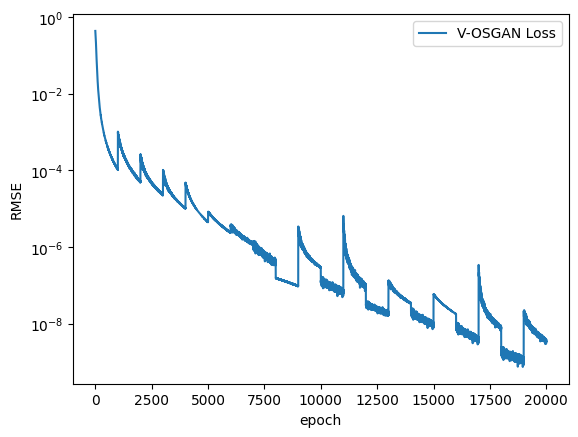

In [ ]:
plt.plot(all_loss)
#plt.plot(dis_loss_list)
#plt.plot(gen_loss_list)
plt.legend(['V-OSGAN Loss','Dis','gen'])
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.yscale('log')

# Preprocessing 2

**Preprocess synthetic data**

In [ ]:
gen_label = []
for i in range(num_of_classes):
    gen_label_temp = np.tile(i, data_to_gen)
    gen_label.extend(gen_label_temp)

gen_label = np.asarray(gen_label, dtype=np.float32)

In [ ]:
gen_data_reshaped = gen_data.reshape(num_of_classes*data_to_gen, data_shape[0])

X_train_gan, Y_train_gan = shuffle(gen_data_reshaped,
                                   gen_label,
                                   random_state=42)

In [ ]:
new_x_train = np.concatenate((X_train, X_train, X_train, X_train, X_train, X_train, X_train, X_train, X_train, X_train, X_train), axis=0)
new_y_train = np.concatenate((Y_train, Y_train, Y_train, Y_train, Y_train, Y_train, Y_train, Y_train, Y_train, Y_train, Y_train), axis=0)

new_x_train, new_y_train = shuffle(new_x_train, new_y_train, random_state=42)
new_y_train_encoded = to_categorical(new_y_train)
new_x_train_transformed = scaler.fit_transform(new_x_train)

In [ ]:
# Split data into train, validation, and test sets
features_train, X_test_gan, labels_train, Y_test_gan = train_test_split(new_x_train_transformed, new_y_train, test_size=0.2, random_state= selection_seed)
features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=valid_split, random_state=42)

features_test = X_test_gan
labels_test = Y_test_gan
Y_test_gan_encoded = to_categorical(Y_test_gan)

# Convert to PyTorch tensors
features_train_tensor = torch.tensor(features_train, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train, dtype=torch.long)
features_val_tensor = torch.tensor(features_val, dtype=torch.float32)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.long)
features_test_tensor = torch.tensor(features_test, dtype=torch.float32)
labels_test_tensor = torch.tensor(labels_test, dtype=torch.long)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(features_train_tensor, labels_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(features_val_tensor, labels_val_tensor), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(features_test_tensor, labels_test_tensor), batch_size=64, shuffle=False)

# Classification with MLP for Real + Synthetic Data

In [ ]:
# Simpan hasil
all_test_loss_gan =[]
gantest_accuracies_mlp = []
ganhistory = []

# Inisialisasi model terbaik
best_model_mlp_gan = None
best_acc_gan = 0

# Training loop
for i in range(times_to_run):
    seed(i * seed_multiplier)
    tf.random.set_seed(i * seed_multiplier)

    model = Sequential()
    model.add(Input(shape=(num_of_features,)))  # Define input shape explicitly
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_of_classes, activation='softmax'))

    model.compile(optimizer=Adam(lr_mlp, 0.5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    ganhistorytemp = model.fit(new_x_train_transformed,
                    new_y_train_encoded,
                    epochs=mlp_epochs,
                    batch_size=64,
                    validation_split=valid_split,
                    verbose = 0)
    ganhistory.append(ganhistorytemp)

    test_loss, test_acc = model.evaluate(X_test_gan,
                                         Y_test_gan_encoded,
                                         verbose=0)

    print(f"#{i} Test acc:", test_acc)
    gantest_accuracies_mlp.append(test_acc)
    all_test_loss_gan.append(test_loss)

    # Simpan model terbaik
    if test_acc > best_acc_gan:
        best_model_mlp_gan = model
        best_acc_gan = test_acc
    else:
        del model
        clear_session()

print("📊 Rata-rata akurasi:", np.mean(gantest_accuracies_mlp))
print("🎯 Akurasi terbaik:", best_acc_gan)

In [ ]:
# Binarisasi label untuk ROC (one-hot)
y_pred_prob = best_model_mlp_gan.predict(X_test_transformed)
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(Y_test_encoded, axis=1)
y_test_bin = label_binarize(y_true, classes=range(num_of_classes))  # shape: (n_samples, n_classes)

# ROC dan AUC per kelas
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Hitung macro average AUC
macro_auc_m2 = np.mean(list(roc_auc.values()))

# Hitung micro average AUC (gabungkan semua prediksi)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
micro_auc_m2 = auc(fpr["micro"], tpr["micro"])

# 🌈 Plot ROC curve untuk beberapa kelas (maks 20)
plt.figure(figsize=(12, 8))
for i in range(min(20, num_of_classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'RP{i} (AUC = {roc_auc[i]:.2f})')

# Tambahkan micro ROC
plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--',
         label=f'Micro-average (AUC = {micro_auc_m2:.2f})')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class + Micro Average")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Print summary
print(f"📊 Macro Average AUC: {macro_auc_m2:.4f}")
print(f"📊 Micro Average AUC: {micro_auc_m2:.4f}")

# Simpan hasil
filename = 'GANROC_MLP.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

# RBFKAN Real + Fake Data

In [ ]:
# Store history untuk akurasi dan loss
gantrain_accuracies_rbfkan = []
ganval_accuracies_rbfkan = []
gantrain_losses_rbfkan = []
ganval_losses_rbfkan = []
gantest_accuracies_rbf = []

ganbest_model_rbfkan = None
ganbest_acc_rbfkan = 0

for i in range(num_iterations):
    print(f"🔁 Iterasi ke-{i+1}")
    torch.manual_seed(i * seed_multiplier)
    np.random.seed(i * seed_multiplier)

    # Inisialisasi model
    model = RBFKAN(
        layers_hidden=[input_dim] + hidden_layers + [output_dim],
        use_base_update=True,
        base_activation=nn.SiLU(),
        spline_weight_init_scale=0.1
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr_rbfkan)
    criterion = nn.CrossEntropyLoss()

    # Simpan akurasi & loss per epoch (untuk satu iterasi)
    train_acc_epochs = []
    val_acc_epochs = []
    train_loss_epochs = []
    val_loss_epochs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_train += (preds == batch_y).sum().item()
            total_train += batch_y.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_loss_epochs.append(avg_train_loss)
        train_acc_epochs.append(train_accuracy)

        # Validasi
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct_val += (preds == val_y).sum().item()
                total_val += val_y.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_loss_epochs.append(avg_val_loss)
        val_acc_epochs.append(val_accuracy)

    # Simpan per-epoch hasil iterasi ini
    gantrain_accuracies_rbfkan.append(train_acc_epochs)
    ganval_accuracies_rbfkan.append(val_acc_epochs)
    gantrain_losses_rbfkan.append(train_loss_epochs)
    ganval_losses_rbfkan.append(val_loss_epochs)

    # Evaluasi akhir di test set
    model.eval()
    with torch.no_grad():
        outputs = model(features_test_tensor)
        preds = torch.argmax(outputs, dim=1)
        test_acc = accuracy_score(labels_test_tensor.numpy(), preds.numpy())
        gantest_accuracies_rbf.append(test_acc)

    print(f"✅ Val acc (last epoch): {val_accuracy:.4f}, Test acc: {test_acc:.4f}")
    if test_acc > ganbest_acc_rbfkan:
        ganbest_model_rbfkan = model
        ganbest_acc_rbfkan = test_acc
    else:
        del model
        torch.cuda.empty_cache()

# Rata-rata per epoch dari semua iterasi
gantrain_accuracies_rbfkan = np.mean(gantrain_accuracies_rbfkan, axis=0)
ganval_accuracies_rbfkan = np.mean(ganval_accuracies_rbfkan, axis=0)
gantrain_losses_rbfkan = np.mean(gantrain_losses_rbfkan, axis=0)
ganval_losses_rbfkan = np.mean(ganval_losses_rbfkan, axis=0)

print("📊 Rata-rata akurasi uji RBFKAN:", np.mean(gantest_accuracies_rbf))
print("🎯 Akurasi terbaik RBFKAN:", ganbest_acc_rbfkan)

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import os

# Pastikan model dalam mode evaluasi
ganbest_model_rbfkan.eval()

# Prediksi probabilitas (softmax)
with torch.no_grad():
    logits = ganbest_model_rbfkan(features_test_tensor)
    y_pred_prob = F.softmax(logits, dim=1).numpy()
    y_true = labels_test_tensor.numpy()

# Binarisasi label untuk ROC (one-hot)
y_test_bin = label_binarize(y_true, classes=range(num_of_classes))  # shape: (n_samples, n_classes)

# ROC dan AUC per kelas
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Hitung macro average AUC
macro_auc_r2 = np.mean(list(roc_auc.values()))

# Hitung micro average AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
micro_auc_r2 = auc(fpr["micro"], tpr["micro"])

# 🌈 Plot ROC curve
plt.figure(figsize=(12, 8))
for i in range(min(20, num_of_classes)):  # Batasi maksimal 20 kelas
    plt.plot(fpr[i], tpr[i], lw=2, label=f'RP{i} (AUC = {roc_auc[i]:.2f})')

# Tambahkan micro average
plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--',
         label=f'Micro-average (AUC = {micro_auc_r2:.2f})')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class + Micro Average (RBFKAN)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Print summary
print(f"📊 Macro Average AUC (RBFKAN): {macro_auc_r2:.4f}")
print(f"📊 Micro Average AUC (RBFKAN): {micro_auc_r2:.4f}")

# Simpan hasil
filename = 'GANROC_RBF.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

# Result

In [ ]:
import matplotlib.pyplot as plt

# MLP metrics
gantrainacc = []
gantrainloss = []
ganvalacc = []
ganvalloss = []

for i in range(len(history)):
    gantrainacc.append(ganhistory[i].history['accuracy'])
    gantrainloss.append(ganhistory[i].history['loss'])
    ganvalacc.append(ganhistory[i].history['val_accuracy'])
    ganvalloss.append(ganhistory[i].history['val_loss'])

ganacc = np.mean(gantrainacc, axis=0)
ganval_acc = np.mean(ganvalacc, axis=0)
ganloss = np.mean(gantrainloss, axis=0)
ganval_loss = np.mean(ganvalloss, axis=0)
ganepochs = range(1, len(ganacc) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, ganacc, 'b>-', label='MLP Training Accuracy')
plt.plot(epochs, ganval_acc, 'b-', label='MLP Validation Accuracy')
plt.plot(epochs, gantrain_accuracies_rbfkan, 'ro--', label='RBFKAN Training Accuracy')
plt.plot(epochs, ganval_accuracies_rbfkan, 'r--', label='RBFKAN Validation Accuracy')
plt.title('Training and Validation Accuracy for {}% Data'.format(fraction_of_data*100))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

filename = 'GAN-Accuracy.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, ganloss, 'b>-', label='MLP Training Loss')
plt.plot(epochs, ganval_loss, 'b-', label='MLP Validation Loss')
plt.plot(epochs, gantrain_losses_rbfkan, 'ro--', label='RBFKAN Training Loss')
plt.plot(epochs, ganval_losses_rbfkan, 'r--', label='RBFKAN Validation Loss')
plt.title('Training and Validation Loss for {}% Data'.format(fraction_of_data*100))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

filename = 'GAN-Loss.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

In [ ]:
# Membaca dataset
file_path = dataset_file
data = pd.read_csv(file_path)

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values - 1  # Normalisasi label ke mulai dari 0

num_features = X.shape[1]
num_classes = len(np.unique(y))

combined_avg_rssi_per_class = []
delta = []

# Tentukan layout grid: misal 4 kolom per baris
n_cols = 5
n_rows = (num_classes + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # Flatten agar bisa diakses seperti list

for i in range(num_classes):
    class_data_gen = gen_data[i, :, :]
    class_data_csv = X[y == i, :]

    avg_rssi_per_feature_gen = class_data_gen.mean(axis=0)
    avg_rssi_per_feature_csv = class_data_csv.mean(axis=0)

    selisih = ((avg_rssi_per_feature_gen - avg_rssi_per_feature_csv)**2)**0.5
    delta.append(selisih)

    combined_avg_rssi = np.vstack((avg_rssi_per_feature_csv, avg_rssi_per_feature_gen)).T
    combined_avg_rssi_per_class.append(combined_avg_rssi)

    ax = axes[i]
    ax.plot(range(num_features), combined_avg_rssi[:, 0], marker='o', linestyle='-', alpha=0.7, label="Real Data")
    ax.plot(range(num_features), combined_avg_rssi[:, 1], marker='s', linestyle='-', alpha=0.7, label="Fake Data")
    ax.set_title(f'RP{i + 1}')
    ax.set_xlabel('Features')
    ax.set_ylabel('Avg RSSI')
    ax.set_xticks(range(num_features))
    ax.set_xticklabels([f'AP{j + 1}' for j in range(num_features)], rotation=45)
    ax.legend()
    ax.grid(True)

# Nonaktifkan subplot kosong jika jumlah kelas tidak genap
for j in range(num_classes, len(axes)):
    fig.delaxes(axes[j])

#fig.suptitle('📶 Average RSSI Value per Feature and Class', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("rssi_avg_per_class_grid.png", dpi=300)
#plt.show()

# Hitung delta rata-rata
def average(lst):
    return sum(lst) / len(lst)

print("Rata-rata delta per kelas:", average(delta))
print("Rata-rata keseluruhan:", average(average(delta)))

filename = 'Pattern.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

In [ ]:
# Standard deviation dari data real (X_train)
std_real = np.std(X_train, axis=0)

# Standard deviation dari data gabungan real + synthetic (new_x_train)
std_combined = np.std(new_x_train, axis=0)

print("📊 Standard Deviation per Fitur:")
for i in range(X_train.shape[1]):
    print(f"AP{i+1}: Real = {std_real[i]:.4f}, Real+Fake = {std_combined[i]:.4f}")

# Jika ingin mean dari seluruh std:
print("\n📈 Rata-rata STD (semua fitur):")
print(f"Real Only     : {np.mean(std_real):.4f}")
print(f"Real + Synthetic: {np.mean(std_combined):.4f}")

In [ ]:
num_features = X_train.shape[1]

# Buat 3x4 grid untuk 11 fitur
n_cols = 6
n_rows = (num_features + n_cols - 1) // n_cols  # hitung baris yang dibutuhkan

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows))
axes = axes.flatten()

for i in range(num_features):
    axes[i].hist(X_train[:, i], bins=30, alpha=0.5, label='Real', color='blue', density=True)
    axes[i].hist(new_x_train[:, i], bins=30, alpha=0.5, label='Real + Fake', color='orange', density=True)
    axes[i].set_title(f'AP{i+1}')
    axes[i].set_xlabel('RSSI (dBm)')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True)

# Matikan sisa subplot jika fitur tidak genap
for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])

# Simpan ke file
plt.savefig('persebaran_data_histogram.png', dpi=300)

filename = 'Deviation.png'
save_path = os.path.join(BASE_FOLDER, filename)
plt.savefig(save_path)

# Save Results

In [ ]:
AccMeanmlp = np.mean(test_accuracies_mlp)
AccStdmlp = np.std(test_accuracies_mlp)
AccMeanrbf = np.mean(test_accuracies_rbf)
AccStdrbf = np.std(test_accuracies_rbf)

GanAccMeanmlp = np.mean(gantest_accuracies_mlp)
GanAccStdmlp = np.std(gantest_accuracies_mlp)
GanAccMeanrbf = np.mean(gantest_accuracies_rbf)
GanAccStdrbf = np.std(gantest_accuracies_rbf)

deltaRSSI = average(delta)
deltaAll = average(average(delta))

lines  = list()
lines.append("Original Data (Each Class: {} Real):".format(num_of_data))
lines.append("Accuracy mean MLP: {}".format(AccMeanmlp))
lines.append("Accuracy STD MLP: {}".format(AccStdmlp))
lines.append("Accuracy mean RBFKAN: {}".format(AccMeanrbf))
lines.append("Accuracy STD RBFKAN: {}".format(AccStdrbf))
lines.append("Micro AUC MLP     : {}".format(micro_auc_m))
lines.append("Micro AUC RBFKAN     : {}".format(micro_auc_r))

lines.append("\n ================== \n")
lines.append("Original + GAN Data" +
             "(Each Class: {} Real + {} GAN):".format(num_of_data,
                                                      data_to_gen))
lines.append("Accuracy mean MLP: {}".format(GanAccMeanmlp))
lines.append("Accuracy STD MLP: {}".format(GanAccStdmlp))
lines.append("Accuracy mean RBFKAN: {}".format(GanAccMeanrbf))
lines.append("Accuracy STD RBFKAN: {}".format(GanAccStdrbf))
lines.append("Micro AUC MLP 2    : {}".format(micro_auc_m2))
lines.append("Micro AUC RBFKAN 2    : {}".format(micro_auc_r2))

lines.append("\n ================== \n")
lines.append("Average RSSI: {}".format(deltaRSSI))
lines.append("average difference All: {}".format(deltaAll))

lines.append("\n ================== \n")
lines.append("STD Real Only     : {}".format(np.mean(std_real)))
lines.append("STD Real + Synthetic: {}".format(np.mean(std_combined)))

lines.append("\n ================== \n")
lines.append("Macro AUC MLP     : {}".format(macro_auc_m))
lines.append("Macro AUC RBFKAN     : {}".format(macro_auc_r))
lines.append("Macro AUC MLP 2    : {}".format(macro_auc_m2))
lines.append("Macro AUC RBFKAN 2    : {}".format(macro_auc_r2))


file_dir = os.path.join(BASE_FOLDER, "result.txt")

with open(file_dir, "w") as filehandle:
    for items in lines:
        filehandle.write(f'{items}\n')

print(f"File berhasil disimpan di: {file_dir}")
